In [1]:
import pandas as pd

In [2]:
# Завантаження набору даних
data = pd.read_pickle('mod_05_topic_10_various_data.pkl')
print(data.keys())


dict_keys(['autos', 'concrete', 'customer', 'accidents'])


In [3]:
concrete_data = data['concrete']
concrete_data.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,CompressiveStrength
0,102.0,153.0,0.0,192.0,0.0,887.0,942.0,25.46
1,108.3,162.4,0.0,203.5,0.0,938.2,849.0,29.23
2,116.0,173.0,0.0,192.0,0.0,909.8,891.9,31.02
3,122.6,183.9,0.0,203.5,0.0,958.2,800.1,33.19
4,132.0,206.5,160.9,178.9,5.5,866.9,735.6,33.31


### Крок2 Використайте прийом підрахунку кількості для створення нової ознаки Components, яка вказуватиме на кількість задіяних складових у різних рецептурах бетону.

In [4]:
# Визначаємо стовпці, які стосуються компонентів бетону
components_columns = ['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 
                      'Superplasticizer', 'CoarseAggregate', 'FineAggregate']

# Створюємо нову ознаку 'Components', що рахує кількість ненульових компонентів у кожному рядку
concrete_data['Components'] = concrete_data[components_columns].gt(0).sum(axis=1)

# Відображаємо перші кілька рядків, щоб перевірити нову ознаку
concrete_data[['Components']].head()

,Components
0,5
1,5
2,5
3,5
4,7


### Крок3. Нормалізуйте набір даних за допомогою об’єкта StandardScaler з пакета sklearn для подальшої кластеризації.

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Створюємо об'єкт StandardScaler
scaler = StandardScaler()

# Масштабуємо всі числові стовпці, включаючи CompressiveStrength
numeric_columns = concrete_data.select_dtypes(include=[np.number]).columns
normalized_data = scaler.fit_transform(concrete_data[numeric_columns])

# Перетворюємо назад у DataFrame для зручності
normalized_df = pd.DataFrame(normalized_data, columns=numeric_columns)

# Перевіряємо результат
normalized_df.head()

normalized_df.head()


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,CompressiveStrength,Components
0,-1.571417,0.785676,-0.937685,0.424376,-1.249389,-0.834174,2.426039,-0.870833,-0.783621
1,-1.510484,0.892770,-0.937685,1.021584,-1.249389,-0.224074,1.155086,-0.628514,-0.783621
2,-1.436011,1.013536,-0.937685,0.424376,-1.249389,-0.562489,1.741364,-0.513461,-0.783621
3,-1.372177,1.137720,-0.937685,1.021584,-1.249389,0.014246,0.486810,-0.373984,-0.783621
4,-1.281261,1.395202,1.491447,-0.255922,-0.230502,-1.073686,-0.394658,-0.366271,1.173140


### Крок4. Визначте оптимальну кількість кластерів за допомогою об'єкта KElbowVisualizer з пакета yellowbrick.

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Обмежує кількість потоків


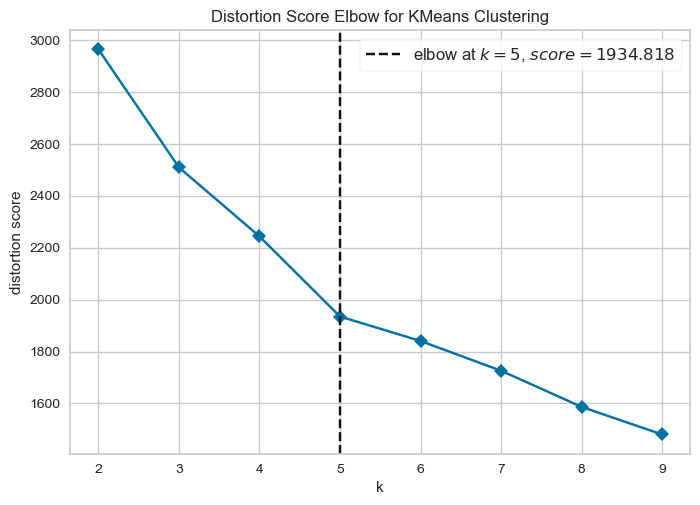

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Створюємо модель KMeans
kmeans = KMeans(random_state=42)

# Візуалізація оптимальної кількості кластерів за допомогою KElbowVisualizer
visualizer = KElbowVisualizer(kmeans, k=(2, 10), timings=False)
visualizer.fit(normalized_data)
visualizer.show()

### Крок 5. Проведіть кластеризацію методом k-середніх і отримайте мітки для кількості кластерів, визначеної на попередньому кроці.

In [8]:
# Створюємо модель KMeans з кількістю кластерів, визначеною на попередньому кроці
kmeans_final = KMeans(n_clusters=5, random_state=42)

# Навчаємо модель на нормалізованих даних
kmeans_final.fit(normalized_data)

# Отримуємо мітки кластерів
concrete_data['Cluster'] = kmeans_final.labels_

# Переглядаємо перші кілька рядків із мітками кластерів
concrete_data[['Cluster']].head()


,Cluster
0,1
1,1
2,1
3,1
4,2


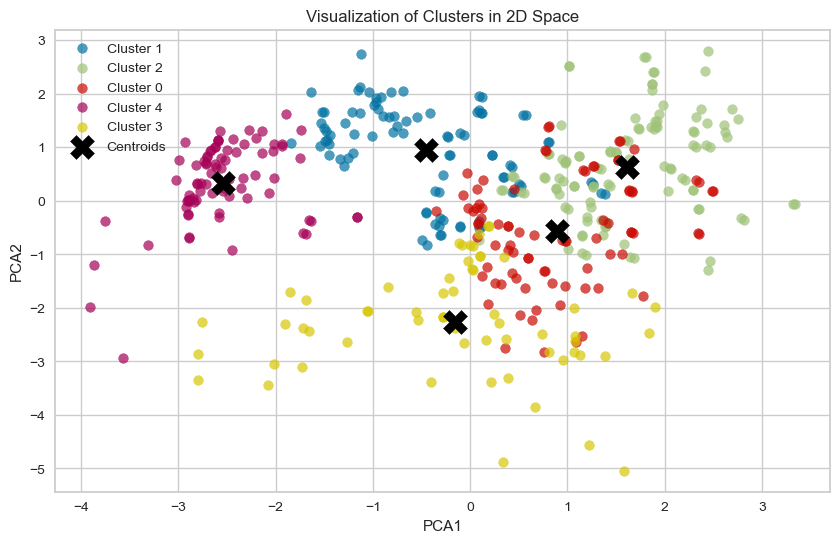

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Виконуємо зменшення розмірності до 2 компонентів для візуалізації
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

# Додаємо координати після PCA до набору даних
concrete_data['PCA1'] = reduced_data[:, 0]
concrete_data['PCA2'] = reduced_data[:, 1]

# Візуалізація кластерів
plt.figure(figsize=(10, 6))
for cluster in concrete_data['Cluster'].unique():
    cluster_data = concrete_data[concrete_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.7)

# Наносимо центроїди кластерів
centroids = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', label='Centroids')

# Налаштування графіка
plt.title('Visualization of Clusters in 2D Space')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid(True)
plt.show()

### Крок6. Використайте оригінальний набір вхідних даних для розрахунку описової статистики кластерів («звіту»)

In [10]:
# Розрахунок описової статистики (медіани) для кожного кластеру
cluster_statistics = concrete_data.groupby('Cluster').median()

# Додавання кількості компонент до описової статистики
cluster_statistics['Components_Count'] = concrete_data.groupby('Cluster')['Components'].sum()

# Виведення результату
cluster_statistics


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,CompressiveStrength,Components,PCA1,PCA2,Components_Count
Cluster,,,,,,,,,,,,
0,203.35,0.00,125.15,170.20,9.65,1004.7,795.55,39.88,6.0,0.779540,-0.580687,517
1,188.10,183.00,0.00,185.75,3.00,973.0,754.65,37.43,6.0,-0.428122,1.124465,500
2,181.00,119.25,113.10,193.90,8.55,879.8,741.20,32.40,7.0,1.584250,0.598407,762
3,387.00,102.05,0.00,162.00,9.80,918.5,786.25,61.66,6.0,0.026525,-2.270566,360
4,339.00,0.00,0.00,189.00,0.00,1040.0,775.00,33.70,4.0,-2.594333,0.403496,338


### Крок7. Додайте до звіту кількість об'єктів (рецептур) у кожному з кластерів.

In [11]:
# Додаємо кількість об'єктів (рецептур) у кожному кластері до звіту
cluster_statistics['Recipe_Count'] = concrete_data.groupby('Cluster').size()

cluster_statistics.drop(columns=['Components_Count'], inplace=True)


# Виведення оновленого звіту
cluster_statistics


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,CompressiveStrength,Components,PCA1,PCA2,Recipe_Count
Cluster,,,,,,,,,,,,
0,203.35,0.00,125.15,170.20,9.65,1004.7,795.55,39.88,6.0,0.779540,-0.580687,84
1,188.10,183.00,0.00,185.75,3.00,973.0,754.65,37.43,6.0,-0.428122,1.124465,90
2,181.00,119.25,113.10,193.90,8.55,879.8,741.20,32.40,7.0,1.584250,0.598407,112
3,387.00,102.05,0.00,162.00,9.80,918.5,786.25,61.66,6.0,0.026525,-2.270566,60
4,339.00,0.00,0.00,189.00,0.00,1040.0,775.00,33.70,4.0,-2.594333,0.403496,81


### Крок8. Проаналізуйте звіт та зробіть висновки.

#### Загальний висновок:
- Кластери демонструють чітке групування за складом рецептури та міцністю бетону.
- Кластер 1 — найбільш поширений і збалансований.
- Кластер 2 — найменш міцний, орієнтований на економію цементу.
- Кластер 4 — має найпростішу рецептуру, сфокусовану на використанні цементу.

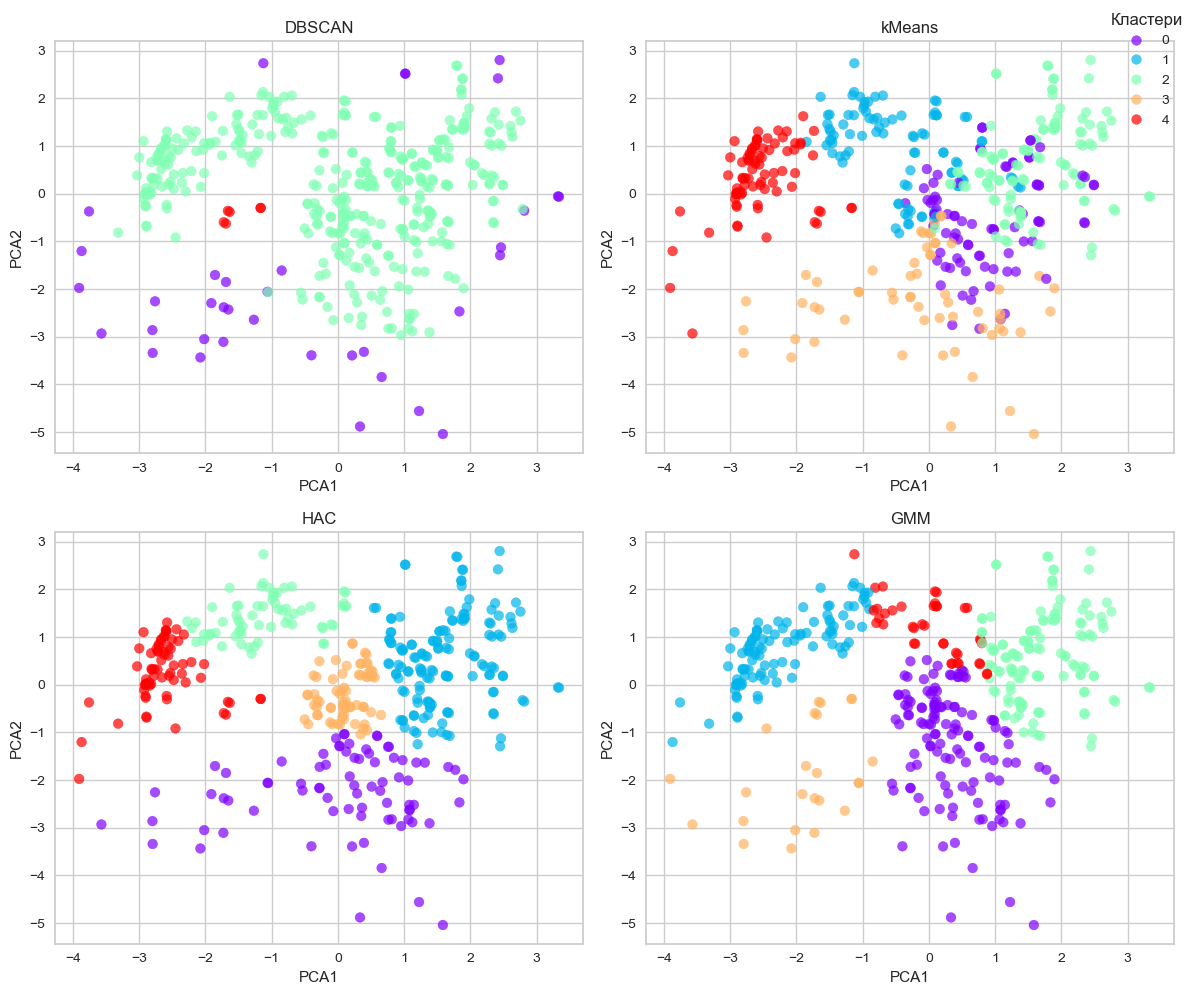

In [12]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import numpy as np

# Створюємо об'єкти для різних методів кластеризації
hac = AgglomerativeClustering(n_clusters=5)
gmm = GaussianMixture(n_components=5, random_state=42)
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Виконуємо кластеризацію
hac_labels = hac.fit_predict(reduced_data)
gmm_labels = gmm.fit_predict(reduced_data)
dbscan_labels = dbscan.fit_predict(reduced_data)

# Готуємо дані для візуалізації
methods = {
    "DBSCAN": dbscan_labels,
    "kMeans": concrete_data['Cluster'],
    "HAC": hac_labels,
    "GMM": gmm_labels,    
}

# Побудова графіків
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (method_name, labels) in zip(axes, methods.items()):
    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='rainbow', alpha=0.7)
    ax.set_title(method_name)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.grid(True)

# Налаштування загальної легенди
handles, labels = scatter.legend_elements()
fig.legend(handles, labels, title="Кластери", loc="upper right")

plt.tight_layout()
plt.show()


1. kMeans:

    - Кластери чітко розділені, особливо якщо дані мають симетричну форму. Підходить для сферичних кластерів.
2. HAC (ієрархічна кластеризація):

    - Дає схожий результат до kMeans, але з невеликими відмінностями через використання іншої метрики. Може краще працювати зі складними структурами.
3. GMM (Gaussian Mixture Model):

    - Добре працює з еліптичними кластерами, враховуючи ймовірнісну модель. Враховує більше варіацій, ніж kMeans.
4. DBSCAN:

    - Виділяє області з високою щільністю. Кластер -1 представляє шумові точки, які не входять до жодного кластера.